In [23]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from census import Census
from us import states
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt
from libpysal.weights import KNN
from esda.moran import Moran_BV
from scipy.stats import pearsonr, spearmanr

In [24]:
df = pd.read_csv('../data/Citywide_Mobility_Survey_2022.csv')
df

,hh_id,num_trips,person_id,person_num,day_id,travel_dow,day_num,is_complete,travel_date,summary_complete,...,no_travel_6,no_travel_7,no_travel_8,no_travel_9,no_travel_11,no_travel_12,no_travel_13,no_travel_99,wkday_weight,svnday_weight
0,22012096,0,2201209601,1,220120960105,7,5,0,10/09/2022,1,...,0,0,0,0,0,0,0,0,0.000000,0.000000
1,22012096,0,2201209601,1,220120960106,1,6,0,10/10/2022,1,...,0,0,0,0,0,0,0,0,0.000000,0.000000
2,22000050,0,2200005001,1,220000500101,4,1,0,10/13/2022,1,...,995,995,995,995,995,995,995,995,0.000000,0.000000
3,22000050,2,2200005001,1,220000500102,5,2,1,10/14/2022,1,...,995,995,995,995,995,995,995,995,0.000000,215.724068
4,22000050,0,2200005001,1,220000500103,6,3,1,10/15/2022,1,...,0,0,0,0,0,0,0,0,0.000000,215.724068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,22145725,3,2214572501,1,221457250104,5,4,1,10/21/2022,1,...,995,995,995,995,995,995,995,995,0.000000,288.523035
15922,22145725,0,2214572501,1,221457250105,6,5,1,10/22/2022,1,...,0,0,0,0,0,0,0,0,0.000000,288.523035
15923,22145725,0,2214572501,1,221457250106,7,6,1,10/23/2022,1,...,0,0,0,0,0,0,0,0,0.000000,288.523035
15924,22145725,8,2214572501,1,221457250107,1,7,1,10/24/2022,1,...,995,995,995,995,995,995,995,995,504.915312,288.523035


In [25]:
selected_df = df[['delivery_2', 'delivery_4', 'delivery_5', 'delivery_6',
                  'delivery_7', 'delivery_8', 'delivery_9', 'shop_online']]
selected_df = selected_df.rename(columns={
    'delivery_2': 'food_delivery',
    'delivery_4': 'grocery_delivery',
    'delivery_5': 'package_delivery',
    'delivery_6': 'package_work_delivery',
    'delivery_7': 'other_loc_delivery',
    'delivery_8': 'other_home_delivery',
    'delivery_9': 'pick_delivery',
    'shop_online': 'online_shopper'
})
selected_df = selected_df[(selected_df.isin([0, 1])).all(axis=1)]
sum_dict = dict(selected_df.sum())

In [26]:
sum_dict

{'food_delivery': np.int64(1291),
 'grocery_delivery': np.int64(407),
 'package_delivery': np.int64(4061),
 'package_work_delivery': np.int64(110),
 'other_loc_delivery': np.int64(264),
 'other_home_delivery': np.int64(110),
 'pick_delivery': np.int64(178),
 'online_shopper': np.int64(2836)}

In [27]:
num_food = int(sum_dict['food_delivery'])
num_grocery = int(sum_dict['grocery_delivery'])
# num_pack = int(sum_dict['package_delivery']) + int(sum_dict['package_work_delivery']) + int(sum_dict['other_loc_delivery']) + int(sum_dict['other_home_delivery']) + int(sum_dict['pick_delivery']) + int(sum_dict['online_shopper'])
num_pack = int(sum_dict['package_delivery']) + int(sum_dict['package_work_delivery']) + int(sum_dict['other_loc_delivery']) + int(sum_dict['other_home_delivery']) + int(sum_dict['pick_delivery'])

In [28]:
num_total = num_food + num_grocery + num_pack
num_total

6421

In [29]:
num_total / len(df) * 8258000 * 365

1215244604.4204447

In [30]:
day_df = pd.read_csv('../data/nyc_survey_2022/Day_2022_20250630.csv')
hh_df = pd.read_csv('../data/nyc_survey_2022/Household_2022_20250630.csv')
person_df = pd.read_csv('../data/nyc_survey_2022/Person_2022_20250630.csv')
trip_df = pd.read_csv('../data/nyc_survey_2022/Trip_2022_20250630.csv')
vehicle_df = pd.read_csv('../data/nyc_survey_2022/Vehicle_2022_20250630.csv')

In [31]:
df = pd.read_csv('../data/Citywide_Mobility_Survey_-_Main_2018_20250630.csv')
df

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_36256/213083508.py:1: DtypeWarning: Columns (245,246,249,250,253,254,288,289,319) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/Citywide_Mobility_Survey_-_Main_2018_20250630.csv')


,Job,DataCollection_StartTime,UniqueID,QDAY,qNTACODE,qGENDER,qAGE,qAGECODE,qRACE,qHISPANIC,...,qFREIGHT_CMB1,qFREIGHT_CMB2,qFREIGHT_CMB3,qFREIGHT_CMB4,qFREIGHT_CMB5,qFREIGHT_CMB6,qFREIGHT_CMB7,qFREIGHT_CMB8,qFREIGHT_CMB9,allwt
0,Online,1.374613e+10,100938,Friday,QN28,Female,38,35-44,White/Caucasian,"No, not of Hispanic, Latino, or Spanish origin",...,No,No,No,No,Yes,No,Yes,No,No,0.288051
1,Online,1.374932e+10,105388,Sunday,QN54,Male,55,55-64,White/Caucasian,"No, not of Hispanic, Latino, or Spanish origin",...,No,No,Yes,Yes,No,No,Yes,No,No,1.223591
2,Online,1.374932e+10,105415,Sunday,MN36,Male,65,65 or older,White/Caucasian,"No, not of Hispanic, Latino, or Spanish origin",...,No,No,No,No,No,Yes,Yes,No,No,0.409954
3,Online,1.374551e+10,100402,Friday,BX06,Male,68,65 or older,White/Caucasian,"No, not of Hispanic, Latino, or Spanish origin",...,No,No,No,No,Yes,No,Yes,No,No,2.398325
4,Online,1.374517e+10,100222,Monday,MN36,Male,50,45-54,White/Caucasian,"No, not of Hispanic, Latino, or Spanish origin",...,No,Yes,Yes,Yes,No,Yes,No,No,No,0.767819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3296,Phone,NaN,50203042,Monday,NaN,Male,54,45-54,Black/ African American/ Caribbean American,"No, not of Hispanic, Latino, or Spanish origin",...,No,No,No,No,No,No,Yes,No,No,0.785581
3297,Phone,NaN,50203043,Monday,NaN,Male,50,45-54,White/Caucasian,"No, not of Hispanic, Latino, or Spanish origin",...,No,No,No,Yes,No,No,No,Yes,No,0.868106
3298,Phone,NaN,50203044,Monday,NaN,Female,41,35-44,White/Caucasian,"No, not of Hispanic, Latino, or Spanish origin",...,No,No,No,No,No,Yes,Yes,No,No,0.492405
3299,Phone,NaN,50203048,Monday,MN23,Male,45,45-54,White/Caucasian,"No, not of Hispanic, Latino, or Spanish origin",...,No,Yes,Yes,No,No,No,No,No,No,1.465169


In [32]:
selected_df = df[['Job',
'UniqueID',
'qGENDER',
'qAGE',
'qRACE',
'qHISPANIC',
'qRACECODE',
'qEDUCATION',
'qINCOME',
'qSURVEYZONE',
'qZIPHOME',
'qBOROUGH',
'qCARACCESS',
'qFREIGHT_CMB1', #daily
'qFREIGHT_CMB2', #several times a week
'qFREIGHT_CMB3', #once a week
'qFREIGHT_CMB4', #a few times a month
'qFREIGHT_CMB5', #once a month
'qFREIGHT_CMB6', #a few times a year
'qFREIGHT_CMB7', #less than a few times a year
'qFREIGHT_CMB8', #dont know
'qCHILDREN',
'qSMARTPHONE']]

In [33]:
no_na_col = ['qINCOME', 'qRACE', 'qCARACCESS', 'qSMARTPHONE', 'qGENDER']

for col_name in no_na_col:
    selected_df = selected_df[selected_df[col_name].notna()]

selected_df['qCHILDREN'] = selected_df['qCHILDREN'].fillna(0)
selected_df = selected_df[selected_df['qRACE']!='Refused']
selected_df = selected_df[selected_df['qINCOME']!='Refused']
selected_df = selected_df.fillna(0)


In [34]:
selected_df.isna().sum()

Job              0
UniqueID         0
qGENDER          0
qAGE             0
qRACE            0
qHISPANIC        0
qRACECODE        0
qEDUCATION       0
qINCOME          0
qSURVEYZONE      0
qZIPHOME         0
qBOROUGH         0
qCARACCESS       0
qFREIGHT_CMB1    0
qFREIGHT_CMB2    0
qFREIGHT_CMB3    0
qFREIGHT_CMB4    0
qFREIGHT_CMB5    0
qFREIGHT_CMB6    0
qFREIGHT_CMB7    0
qFREIGHT_CMB8    0
qCHILDREN        0
qSMARTPHONE      0
dtype: int64

In [35]:
selected_df['qFREIGHT_CMB1'].value_counts()

qFREIGHT_CMB1
No     2785
Yes     186
Name: count, dtype: int64

In [36]:
child_val = {'One':1, 'Two':2, 'Three':3, 'Four or more':4, 'Refused':0, 0:0}

def get_freq(row):
    if row['qFREIGHT_CMB1']=='Yes' or row['qFREIGHT_CMB2']=='Yes':
        return 5
    elif row['qFREIGHT_CMB3']=='Yes':
        return 4
    elif row['qFREIGHT_CMB4']=='Yes':
        return 3
    elif row['qFREIGHT_CMB5']=='Yes':
        return 2
    else:
        return 1
        

reg_rows = []
for _, row in selected_df.iterrows():
    reg_row = {}
    reg_row['age'] = int(row['qAGE'])
    reg_row['black'] = int(row['qRACE']=='Black/ African American/ Caribbean American')
    reg_row['asian'] = int(row['qRACE']=='Asian')
    reg_row['other_race'] = int(row['qRACE']=='Other')
    reg_row['smartphone'] = int(row['qSMARTPHONE']=='Yes')
    reg_row['income_50_75'] = int(row['qINCOME']=='$50,000 - $74,999')
    reg_row['income_75_100'] = int(row['qINCOME']=='$75,000 - $99,999')
    reg_row['income_100'] = int(row['qINCOME']=='$100,000 - $149,999' or row['qINCOME']=='$150,000-$199,999' or row['qINCOME']=='$200,000 and above')
    reg_row['male'] = int(row['qGENDER']=='Male')
    reg_row['zipcode'] = int(row['qZIPHOME'])
    reg_row['car_access'] = int(row['qCARACCESS']=='I do not personally own or lease a car, but I have access to a car belonging to a member of my household'
                                or row['qCARACCESS']=='I personally own or lease a car')
    reg_row['children'] = int(child_val[row['qCHILDREN']])
    reg_row['del_freq'] = int(get_freq(row))

    reg_rows.append(reg_row)

reg_df = pd.DataFrame(reg_rows)
reg_df

,age,black,asian,other_race,smartphone,income_50_75,income_75_100,income_100,male,zipcode,car_access,children,del_freq
0,38,0,0,0,1,0,0,1,0,11372,1,0,2
1,55,0,0,0,1,0,0,1,1,11201,0,0,4
2,65,0,0,0,1,0,0,0,1,10039,0,0,1
3,68,0,0,0,1,0,0,0,1,11205,0,0,2
4,50,0,0,0,1,0,0,1,1,11235,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,54,1,0,0,1,0,1,0,1,10027,0,0,1
2967,50,0,0,0,1,0,0,0,1,10032,0,0,3
2968,41,0,0,0,1,0,0,1,0,10033,0,0,1
2969,45,0,0,0,1,0,0,1,1,10003,1,0,5


In [37]:
# Select independent variables (exclude zipcode and dependent)
indep_vars = ['age', 'black', 'asian', 'other_race', 'smartphone',
              'income_50_75', 'income_75_100', 'income_100', 'male',
              'car_access', 'children']

X = reg_df[indep_vars]
y = reg_df['del_freq']

# Make sure y is an ordered categorical variable
y_cat = y.astype('category')


In [38]:
model = OrderedModel(y_cat, X, distr='probit')

result = model.fit(method='bfgs')
print(result.summary())


/opt/anaconda3/envs/ox/lib/python3.13/site-packages/statsmodels/miscmodels/ordinal_model.py:205: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "


Optimization terminated successfully.
         Current function value: 1.505269
         Iterations: 31
         Function evaluations: 39
         Gradient evaluations: 39
                             OrderedModel Results                             
Dep. Variable:               del_freq   Log-Likelihood:                -4472.2
Model:                   OrderedModel   AIC:                             8974.
Method:            Maximum Likelihood   BIC:                             9064.
Date:                Wed, 09 Jul 2025                                         
Time:                        22:07:56                                         
No. Observations:                2971                                         
Df Residuals:                    2956                                         
Df Model:                          11                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [39]:
# Base predicted probabilities
pred_probs = result.model.predict(result.params, exog=X)

def marginal_effect_continuous(var_name, delta=1):
    X_plus = X.copy()
    X_plus[var_name] += delta
    pred_probs_plus = result.model.predict(result.params, exog=X_plus)
    # Marginal effect approx: change in probabilities divided by delta
    me = (pred_probs_plus - pred_probs) / delta
    return me.mean(axis=0)  # average marginal effect on each category

# Example: marginal effect of 'age' increasing by 1 year
me_age = marginal_effect_continuous('age')
print(f"Marginal effects of increasing age by 1 unit on each del_freq category:\n{me_age}")


Marginal effects of increasing age by 1 unit on each del_freq category:
[-8.70311057e-07 -1.98370161e-07 -1.89191177e-07  2.01024680e-07
  1.05684772e-06]


In [40]:
def marginal_effect_dummy(var_name):
    X_base = X.copy()
    X_base[var_name] = 0
    X_alt = X.copy()
    X_alt[var_name] = 1
    pred_base = result.model.predict(result.params, exog=X_base)
    pred_alt = result.model.predict(result.params, exog=X_alt)
    me = pred_alt - pred_base
    return me.mean(axis=0)

me_black = marginal_effect_dummy('black')
print(f"Marginal effects of changing black from 0 to 1 on each del_freq category:\n{me_black}")


Marginal effects of changing black from 0 to 1 on each del_freq category:
[ 0.06064371  0.01317821  0.01099125 -0.01498802 -0.06982515]


In [41]:
census = pd.read_csv('../data/nyc_census/ACSDT5Y2023.B01003-Data.csv')
census

,GEO_ID,NAME,B01003_001E,B01003_001M,Unnamed: 4
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,NaN
1,1400000US36001000100,Census Tract 1; Albany County; New York,2156,441,NaN
2,1400000US36001000201,Census Tract 2.01; Albany County; New York,2519,583,NaN
3,1400000US36001000202,Census Tract 2.02; Albany County; New York,2436,690,NaN
4,1400000US36001000301,Census Tract 3.01; Albany County; New York,2378,680,NaN
...,...,...,...,...,...
5392,1400000US36123150301,Census Tract 1503.01; Yates County; New York,2907,253,NaN
5393,1400000US36123150302,Census Tract 1503.02; Yates County; New York,2066,183,NaN
5394,1400000US36123150400,Census Tract 1504; Yates County; New York,3798,284,NaN
5395,1400000US36123150501,Census Tract 1505.01; Yates County; New York,2040,321,NaN


In [42]:
c = Census("091bc4111cd44207207b90bb4a31394e89296375")
c.acs5.get(('NAME', 'B25034_010E'),
          {'for': 'state:{}'.format(states.MD.fips)})

[{'NAME': 'Maryland', 'B25034_010E': 129256.0, 'state': '24'}]

In [43]:
API_KEY = "091bc4111cd44207207b90bb4a31394e89296375"
c = Census(API_KEY)

# --- Get raw ACS data ---

# B01001: Sex by Age
b01001_vars = ['B01001_001E'] + [f'B01001_{str(i).zfill(3)}E' for i in range(3, 50)]  # Skip 2 (female total), get age bins

# B02001: Race
b02001_vars = ['B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_005E']  # total, white, black, asian

# B28001: Computer + Internet
b28001_vars = ['B28001_001E', 'B28001_007E']  # total, smartphone only

# B19001: Income
b19001_vars = [f'B19001_{str(i).zfill(3)}E' for i in range(1, 18)]

# B08201: Vehicles
b08201_vars = ['B08201_001E', 'B08201_002E']  # total HHs, no vehicle

# B11005 + B11001: Children and Households
b11005_vars = ['B11005_001E', 'B11005_002E']  # total people, children <18
b11001_vars = ['B11001_001E']  # total households

# All variables
all_vars = b01001_vars + b02001_vars + b28001_vars + b19001_vars + b08201_vars + b11005_vars + b11001_vars

# Pull all tracts in New York (state FIPS = 36)
data = c.acs5.get(all_vars, {'for': 'tract:*', 'in': 'state:36 county:*'})

tract_df = pd.DataFrame(data)

# Convert numeric columns
for col in df.columns:
    if col.startswith('B'):
        tract_df[col] = pd.to_numeric(tract_df[col], errors='coerce')

# 1. Mean age approximation (use midpoint of age bins)
age_bins = {
    'B01001_003E': 2, 'B01001_004E': 5, 'B01001_005E': 7.5, 'B01001_006E': 10, 'B01001_007E': 12.5,
    'B01001_008E': 15, 'B01001_009E': 17.5, 'B01001_010E': 20, 'B01001_011E': 22.5, 'B01001_012E': 25,
    'B01001_013E': 27.5, 'B01001_014E': 30, 'B01001_015E': 32.5, 'B01001_016E': 35, 'B01001_017E': 37.5,
    'B01001_018E': 40, 'B01001_019E': 42.5, 'B01001_020E': 45, 'B01001_021E': 47.5, 'B01001_022E': 50,
    'B01001_023E': 52.5, 'B01001_024E': 55, 'B01001_025E': 60,
    'B01001_027E': 2, 'B01001_028E': 5, 'B01001_029E': 7.5, 'B01001_030E': 10, 'B01001_031E': 12.5,
    'B01001_032E': 15, 'B01001_033E': 17.5, 'B01001_034E': 20, 'B01001_035E': 22.5, 'B01001_036E': 25,
    'B01001_037E': 27.5, 'B01001_038E': 30, 'B01001_039E': 32.5, 'B01001_040E': 35, 'B01001_041E': 37.5,
    'B01001_042E': 40, 'B01001_043E': 42.5, 'B01001_044E': 45, 'B01001_045E': 47.5, 'B01001_046E': 50,
    'B01001_047E': 52.5, 'B01001_048E': 55, 'B01001_049E': 60
}
tract_df['mean_age'] = sum(tract_df[k] * v for k, v in age_bins.items()) / tract_df['B01001_001E']

# 2. Percent black
tract_df['pct_black'] = tract_df['B02001_003E'] / tract_df['B02001_001E']

# 3. Percent asian
tract_df['pct_asian'] = tract_df['B02001_005E'] / tract_df['B02001_001E']

# 4. Percent other race
tract_df['pct_other_race'] = 1 - (
    tract_df['B02001_002E'] + tract_df['B02001_003E'] + tract_df['B02001_005E']) / tract_df['B02001_001E']

# 5. Smartphone ownership rate (proxy)
tract_df['pct_smartphone'] = 1 - tract_df['B28001_007E'] / tract_df['B28001_001E']

# 6–8. Income brackets
tract_df['pct_income_50_75'] = (tract_df['B19001_011E'] + tract_df['B19001_012E']) / tract_df['B19001_001E']
tract_df['pct_income_75_100'] = (tract_df['B19001_013E'] + tract_df['B19001_014E']) / tract_df['B19001_001E']
tract_df['pct_income_100'] = (tract_df['B19001_015E'] + tract_df['B19001_016E'] + tract_df['B19001_017E']) / tract_df['B19001_001E']

# 9. Percent male
male_total = sum(tract_df[f'B01001_{str(i).zfill(3)}E'] for i in range(3, 25))
tract_df['pct_male'] = male_total / tract_df['B01001_001E']

# 10. Percent households with car
tract_df['pct_car_access'] = 1 - tract_df['B08201_002E'] / tract_df['B08201_001E']

# 11. Children per household
tract_df['children_per_hh'] = tract_df['B11005_002E'] / tract_df['B11001_001E']

# Add full GEOID for mapping
tract_df['geoid'] = tract_df['state'] + tract_df['county'] + tract_df['tract']

tract_df

,B01001_001E,B01001_003E,B01001_004E,B01001_005E,B01001_006E,B01001_007E,B01001_008E,B01001_009E,B01001_010E,B01001_011E,...,pct_asian,pct_other_race,pct_smartphone,pct_income_50_75,pct_income_75_100,pct_income_100,pct_male,pct_car_access,children_per_hh,geoid
0,2156.0,30.0,56.0,101.0,96.0,19.0,23.0,0.0,96.0,6.0,...,0.011596,0.228200,0.475578,0.186375,0.239075,0.062982,0.399351,0.807198,0.388175,36001000100
1,2519.0,69.0,52.0,39.0,0.0,88.0,73.0,0.0,0.0,48.0,...,0.035331,0.131401,0.572750,0.155593,0.174096,0.092515,0.538706,0.597981,0.198486,36001000201
2,2436.0,206.0,137.0,115.0,0.0,52.0,51.0,0.0,40.0,195.0,...,0.000000,0.083744,0.504595,0.197995,0.102757,0.109440,0.531199,0.722640,0.330827,36001000202
3,2378.0,67.0,51.0,125.0,176.0,7.0,0.0,0.0,61.0,144.0,...,0.009251,0.137511,0.475748,0.192982,0.105263,0.085655,0.550463,0.590299,0.288958,36001000301
4,3273.0,237.0,74.0,0.0,8.0,12.0,52.0,51.0,106.0,224.0,...,0.043996,0.120684,0.384532,0.167756,0.172658,0.196078,0.435991,0.748911,0.160131,36001000302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5391,2907.0,58.0,89.0,90.0,46.0,25.0,26.0,12.0,78.0,97.0,...,0.006192,0.029240,0.430476,0.223810,0.281905,0.189524,0.489508,0.929524,0.271429,36123150301
5392,2066.0,62.0,90.0,35.0,48.0,5.0,4.0,0.0,27.0,22.0,...,0.068732,0.021297,0.494700,0.131920,0.261484,0.156655,0.530978,0.885748,0.243816,36123150302
5393,3798.0,90.0,76.0,100.0,13.0,135.0,143.0,18.0,68.0,163.0,...,0.000000,0.014481,0.385299,0.076737,0.254443,0.318255,0.474987,0.891761,0.235057,36123150400
5394,2040.0,72.0,82.0,66.0,8.0,8.0,0.0,0.0,18.0,14.0,...,0.000000,0.075000,0.699161,0.162474,0.291405,0.169811,0.383333,0.893082,0.219078,36123150501


In [44]:
# STEP 1: Prepare the input data for prediction
tract_X = tract_df[[
    'mean_age', 'pct_black', 'pct_asian', 'pct_other_race',
    'pct_smartphone', 'pct_income_50_75', 'pct_income_75_100', 'pct_income_100',
    'pct_male', 'pct_car_access', 'children_per_hh'
]].copy()

# Rename columns to match those used in the regression model
tract_X.columns = [
    'age', 'black', 'asian', 'other_race',
    'smartphone', 'income_50_75', 'income_75_100', 'income_100',
    'male', 'car_access', 'children'
]

# STEP 2: Predict probability distribution for each del_freq category
probs = result.model.predict(result.params, exog=tract_X)

# STEP 3: Compute expected del_freq (as sum of category × probability)
categories = np.arange(1, probs.shape[1] + 1)  # [1, 2, 3, 4, 5]
tract_df['expected_del_freq'] = (probs * categories).sum(axis=1)

# STEP 4: Preview output
print(tract_df[['geoid', 'expected_del_freq']].head())


         geoid  expected_del_freq
0  36001000100           2.993870
1  36001000201           2.937472
2  36001000202           2.904358
3  36001000301           2.949614
4  36001000302           3.007809


In [45]:
tract_df['total_deliveries'] = tract_df['expected_del_freq'] * tract_df['B01001_001E']

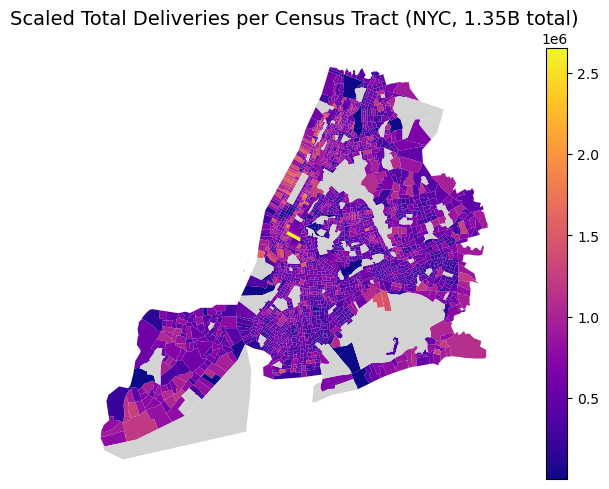

In [46]:
# STEP 1: Load shapefiles
tracts = gpd.read_file("../data/nyc_census/tl_2023_36_tract.shp")
boroughs = gpd.read_file("../data/nyc_boroughs.geojson")

# Ensure CRS match for spatial join
tracts = tracts.to_crs(boroughs.crs)

# STEP 2: Spatial filter — keep only NYC tracts
tracts_nyc = gpd.sjoin(tracts, boroughs, how="inner", predicate="intersects")

# Rebuild GEOID
tracts_nyc['geoid'] = tracts_nyc['STATEFP'] + tracts_nyc['COUNTYFP'] + tracts_nyc['TRACTCE']

# STEP 3: Merge with delivery predictions
tracts_nyc = tracts_nyc.merge(
    tract_df[['geoid', 'expected_del_freq', 'B01001_001E']],
    on='geoid',
    how='left'
)

# STEP 4: Compute raw tract-level totals
tracts_nyc['raw_total_deliveries'] = tracts_nyc['expected_del_freq'] * tracts_nyc['B01001_001E']

# STEP 5: Scale so total equals 1,350,500,000
total_raw = tracts_nyc['raw_total_deliveries'].sum()
scaling_factor = 1_350_500_000 / total_raw
tracts_nyc['scaled_total_deliveries'] = tracts_nyc['raw_total_deliveries'] * scaling_factor

# STEP 6: Plot
tracts_nyc.to_crs(epsg=3857).plot(
    column='scaled_total_deliveries',
    cmap='plasma',
    legend=True,
    figsize=(8, 5),
    edgecolor='none',
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

plt.title("Scaled Total Deliveries per Census Tract (NYC, 1.35B total)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


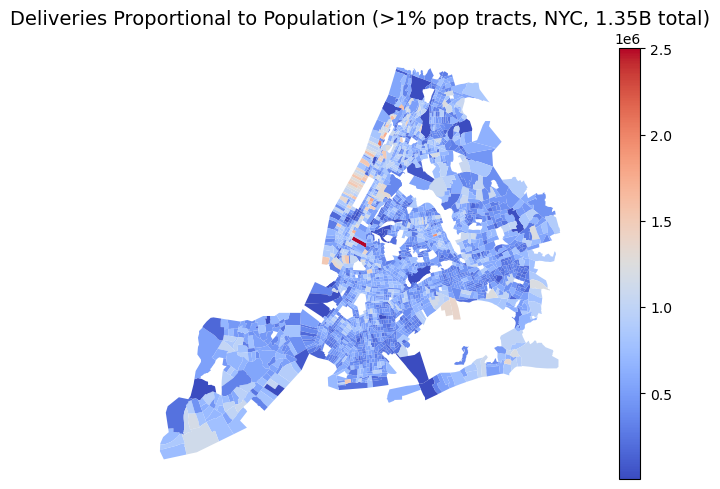

In [47]:
# STEP 1: Compute 1st percentile threshold
pop_threshold = tracts_nyc['B01001_001E'].quantile(0.005)

# STEP 2: Filter out low-population tracts
tracts_nyc_filtered = tracts_nyc[tracts_nyc['B01001_001E'] > pop_threshold].copy()

# STEP 3: Recalculate total population
total_pop_filtered = tracts_nyc_filtered['B01001_001E'].sum()

# STEP 4: Compute deliveries proportional to population
tracts_nyc_filtered['pop_scaled_deliveries'] = (
    tracts_nyc_filtered['B01001_001E'] / total_pop_filtered * 1_350_500_000
)

# STEP 5: Plot
tracts_nyc_filtered.to_crs(epsg=3857).plot(
    column='pop_scaled_deliveries',
    cmap='coolwarm',
    legend=True,
    figsize=(8, 5),
    edgecolor='none',
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

plt.title("Deliveries Proportional to Population (>1% pop tracts, NYC, 1.35B total)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


In [48]:
tracts_nyc['B01001_001E'].describe()

count     2442.000000
mean      3683.158886
std       2065.772008
min          0.000000
25%       2281.000000
50%       3444.500000
75%       4822.750000
max      16684.000000
Name: B01001_001E, dtype: float64

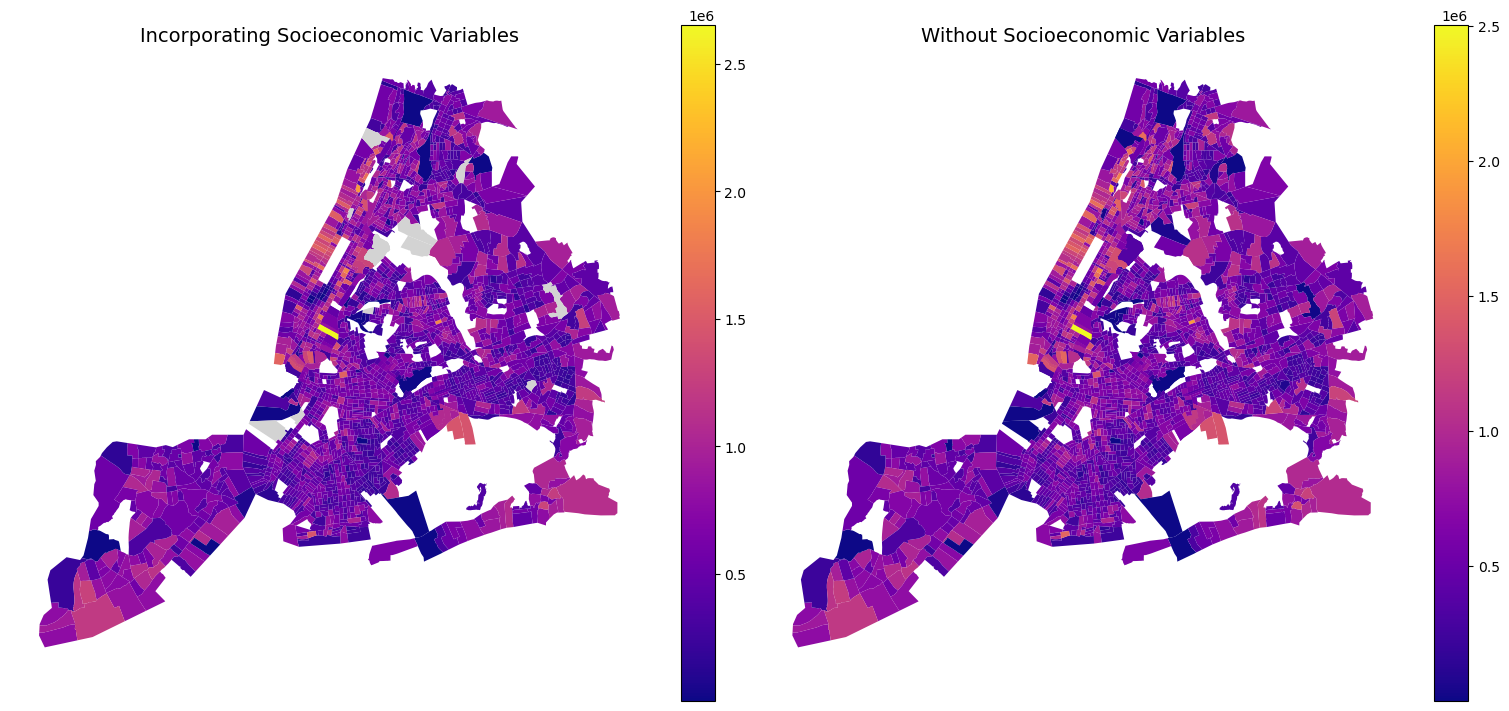

In [49]:
# Set CRS for plotting
plot_gdf = tracts_nyc_filtered.to_crs(epsg=3857)

fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)

# Map 1: Model-based deliveries
plot_gdf.plot(
    column='scaled_total_deliveries',
    cmap='plasma',
    legend=True,
    ax=axes[0],
    edgecolor='none',
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
axes[0].set_title("Incorporating Socioeconomic Variables", fontsize=14)
axes[0].axis('off')

# Map 2: Population proportional deliveries
plot_gdf.plot(
    column='pop_scaled_deliveries',
    cmap='plasma',
    legend=True,
    ax=axes[1],
    edgecolor='none',
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
axes[1].set_title("Without Socioeconomic Variables", fontsize=14)
axes[1].axis('off')

plt.show()

In [50]:
x = tracts_nyc_filtered['scaled_total_deliveries']
y = tracts_nyc_filtered['pop_scaled_deliveries']

# Boolean mask for finite, non-null values in both arrays
mask = (~x.isna()) & (~y.isna()) & np.isfinite(x) & np.isfinite(y)

x_clean = x[mask]
y_clean = y[mask]

print(f"Valid data points: {len(x_clean)}")


Valid data points: 2333


In [51]:
pearson_corr, pearson_p = pearsonr(x_clean, y_clean)
spearman_corr, spearman_p = spearmanr(x_clean, y_clean)

print(f"Pearson r = {pearson_corr:.3f} (p={pearson_p:.3g})")
print(f"Spearman rho = {spearman_corr:.3f} (p={spearman_p:.3g})")


Pearson r = 0.996 (p=0)
Spearman rho = 0.997 (p=0)


In [53]:
plot_gdf.to_file("../data/nyc_census/output/demand_distribution_census.shp")

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_36256/418544333.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  plot_gdf.to_file("../data/nyc_census/output/demand_distribution_census.shp")
/opt/anaconda3/envs/ox/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
/opt/anaconda3/envs/ox/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'geoid' to 'geoid_1'
  ogr_write(
/opt/anaconda3/envs/ox/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'expected_del_freq' to 'expected_d'
  ogr_write(
/opt/anaconda3/envs/ox/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B01001_001E' to 'B01001_001'
  ogr_write(
/opt/anaconda3/envs/ox/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning:

In [54]:
# Drop rows with missing values in the columns of interest
plot_gdf_clean = plot_gdf.dropna(subset=['scaled_total_deliveries', 'pop_scaled_deliveries'])

# Create K-Nearest Neighbors spatial weights with k=5
w = KNN.from_dataframe(plot_gdf_clean, k=5)
w.transform = 'r'  # row-standardize

# Compute Bivariate Moran's I
moran_bv = Moran_BV(plot_gdf_clean['scaled_total_deliveries'], 
                   plot_gdf_clean['pop_scaled_deliveries'], w)

print("Bivariate Moran's I:", moran_bv.I)
print("p-value:", moran_bv.p_sim)


Bivariate Moran's I: 0.35364130766348706
p-value: 0.001
